In [2]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np 



/Users/wangbeini/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/wangbeini/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [8]:
# Optional: if you just loaded the CSV
file_path = '/Users/wangbeini/Documents/Columbia U/5243-bio/final project/data + codebook/filtered_expression_matrix_by_probe.csv'
df_sig = pd.read_csv(file_path, index_col=0)

# Define time point groups
timepoints = ['0h', '24h', '48h', '72h']
timepoint_groups = {
    tp: [col for col in df_sig.columns if f'RANKL_{tp}_' in col]
    for tp in timepoints
}


In [9]:

df_mean_per_time = pd.DataFrame(index=df_sig.index)

for tp, cols in timepoint_groups.items():
    df_mean_per_time[f'{tp}_mean'] = df_sig[cols].mean(axis=1)

df_mean_per_time.index.name = "Probe_ID"  


df_mean_per_time.to_csv("expression_probe_mean_per_timepoint.csv")
df_mean_per_time

,0h_mean,24h_mean,48h_mean,72h_mean
Probe_ID,,,,
ILMN_1212602,1.922745,1.828810,3.575561,4.425662
ILMN_1212605,5.769999,5.885450,5.012978,5.293009
ILMN_1212607,2.132698,2.077371,2.196588,2.170909
ILMN_1212619,3.207935,2.710071,2.605490,2.719356
ILMN_1212625,5.924061,6.743062,5.870514,5.856313
...,...,...,...,...
ILMN_3163539,5.475569,6.896090,6.113329,5.832092
ILMN_3163543,2.575353,2.688908,2.633180,2.603446
ILMN_3163569,2.438726,2.398066,2.402005,2.433590


##base line: kmeans cluster##

In [10]:


# Optional: scale features (important for k-means)

X_scaled = df_mean_per_time.copy()
X_scaled.iloc[:, :] = X_scaled.iloc[:, :].sub(X_scaled.iloc[:, 0], axis=0)



In [11]:
X_scaled

,0h_mean,24h_mean,48h_mean,72h_mean
Probe_ID,,,,
ILMN_1212602,0.0,-0.093936,1.652815,2.502917
ILMN_1212605,0.0,0.115451,-0.757021,-0.476990
ILMN_1212607,0.0,-0.055327,0.063890,0.038211
ILMN_1212619,0.0,-0.497864,-0.602445,-0.488579
ILMN_1212625,0.0,0.819001,-0.053547,-0.067749
...,...,...,...,...
ILMN_3163539,0.0,1.420521,0.637760,0.356523
ILMN_3163543,0.0,0.113555,0.057827,0.028093
ILMN_3163569,0.0,-0.040660,-0.036721,-0.005136


In [12]:
X_scaled.to_csv("X_scaled.csv",index=False)


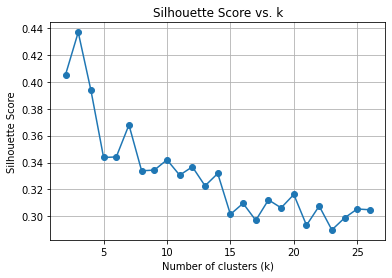

Best k based on silhouette score: 3


In [17]:

# Try k from 2 to 10 and compute silhouette score
range_k = range(2, 27)
sil_scores = []

for k in range_k:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(range_k, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k")
plt.grid(True)
plt.show()

# Pick the best k (highest silhouette score)
best_k = range_k[sil_scores.index(max(sil_scores))]
print(f"Best k based on silhouette score: {best_k}")


/var/folders/5g/1ml1dkqn1hx0_z8kyhhg3wqw0000gn/T/ipykernel_16058/2848829070.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/wangbeini/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


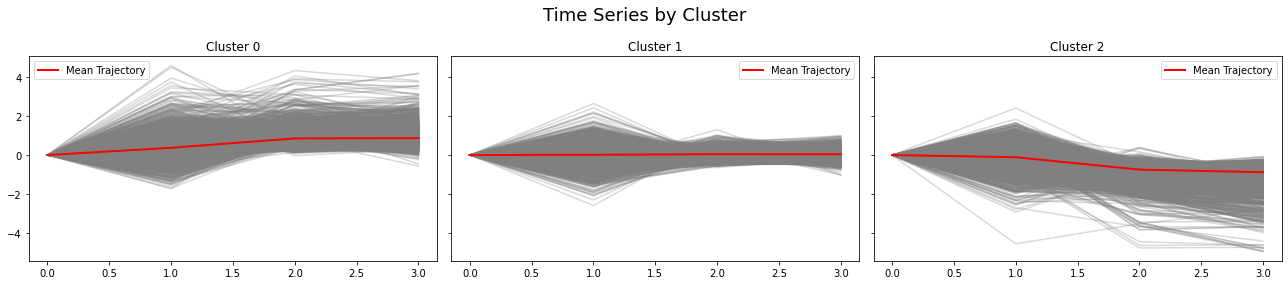

In [85]:

kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# 3. Visualization: 3 example plots per cluster
k = 3  # number of clusters

fig, axes = plt.subplots(1, k, figsize=(18, 4), sharey=True)
fig.suptitle("Time Series by Cluster", fontsize=18)

for cluster_id in range(k):
    ax = axes[cluster_id]
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_data = X_scaled.to_numpy()[cluster_indices]

    for ts in cluster_data:
        ax.plot(ts, color='gray', alpha=0.3)

    mean_ts = np.mean(cluster_data, axis=0)
    ax.plot(mean_ts, color='red', linewidth=2, label='Mean Trajectory')
    ax.set_title(f"Cluster {cluster_id}")
    ax.legend()

plt.tight_layout()
plt.show()

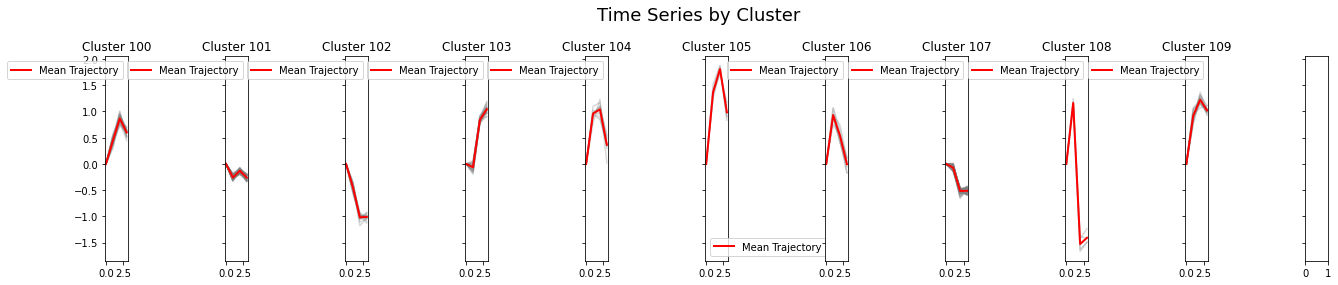

In [ ]:
kmeans = KMeans(n_clusters=729, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# 3. Visualization: 3 example plots per cluster
k = 10  # number of clusters

fig, axes = plt.subplots(1, k, figsize=(18, 4), sharey=True)
fig.suptitle("Time Series by Cluster", fontsize=18)

for cluster_id in range(k):
    ax = axes[cluster_id]
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_data = X_scaled.to_numpy()[cluster_indices]

    for ts in cluster_data:
        ax.plot(ts, color='gray', alpha=0.3)

    mean_ts = np.mean(cluster_data, axis=0)
    ax.plot(mean_ts, color='red', linewidth=2, label='Mean Trajectory')
    ax.set_title(f"Cluster {cluster_id}")
    ax.legend()

plt.tight_layout()
plt.show()

In [87]:
score = silhouette_score(X_scaled, cluster_labels)
score

0.22965042116016

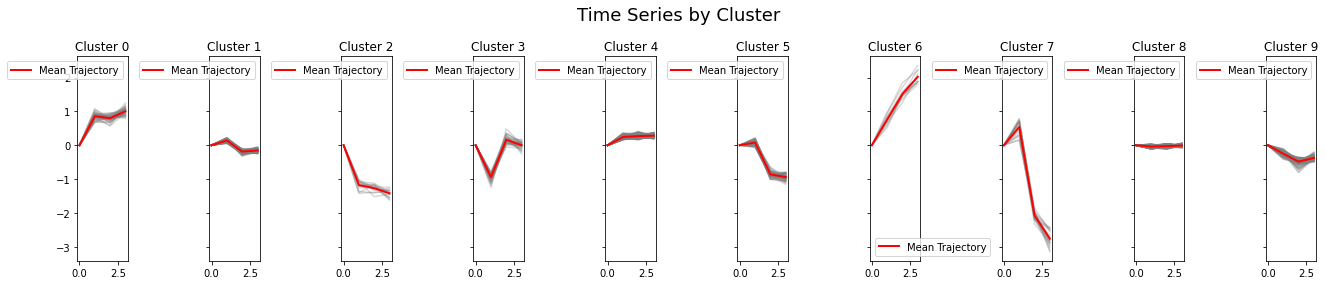

In [92]:
kmeans = KMeans(n_clusters=300, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# 3. Visualization: 3 example plots per cluster
k = 10  # number of clusters

fig, axes = plt.subplots(1, k, figsize=(18, 4), sharey=True)
fig.suptitle("Time Series by Cluster", fontsize=18)

for cluster_id in range(k):
    ax = axes[cluster_id]
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_data = X_scaled.to_numpy()[cluster_indices]

    for ts in cluster_data:
        ax.plot(ts, color='gray', alpha=0.3)

    mean_ts = np.mean(cluster_data, axis=0)
    ax.plot(mean_ts, color='red', linewidth=2, label='Mean Trajectory')
    ax.set_title(f"Cluster {cluster_id}")
    ax.legend()

plt.tight_layout()
plt.show()

In [93]:

# Store in a new df or overwrite
df_clustered = df_mean_per_time.copy()
df_clustered['cluster'] = cluster_labels

# Check results
print(df_clustered['cluster'].value_counts())

cluster
102    663
8      636
29     622
149    581
233    489
      ... 
125      1
162      1
265      1
222      1
77       1
Name: count, Length: 300, dtype: int64


In [115]:
# Count how many clusters have only 1 element
singletons = df_clustered['cluster'].value_counts()
num_singleton_clusters = (singletons == 3).sum()
print(f"Number of singleton clusters: {num_singleton_clusters}")


Number of singleton clusters: 11


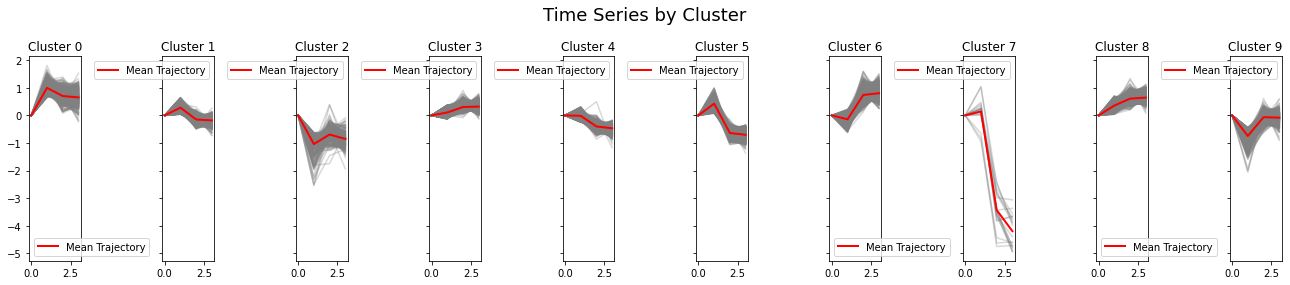

In [24]:
kmeans = KMeans(n_clusters=27, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# 3. Visualization: 3 example plots per cluster
k = 10  # number of clusters

fig, axes = plt.subplots(1, k, figsize=(18, 4), sharey=True)
fig.suptitle("Time Series by Cluster", fontsize=18)

for cluster_id in range(k):
    ax = axes[cluster_id]
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_data = X_scaled.to_numpy()[cluster_indices]

    for ts in cluster_data:
        ax.plot(ts, color='gray', alpha=0.3)

    mean_ts = np.mean(cluster_data, axis=0)
    ax.plot(mean_ts, color='red', linewidth=2, label='Mean Trajectory')
    ax.set_title(f"Cluster {cluster_id}")
    ax.legend()

plt.tight_layout()
plt.show()

In [26]:
from collections import Counter

# Count elements per cluster
cluster_counts = Counter(cluster_labels)

# Print counts
for cluster_id in range(k):
    print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} elements")


Cluster 0: 395 elements
Cluster 1: 1415 elements
Cluster 2: 260 elements
Cluster 3: 1930 elements
Cluster 4: 1145 elements
Cluster 5: 618 elements
Cluster 6: 650 elements
Cluster 7: 20 elements
Cluster 8: 815 elements
Cluster 9: 543 elements


Number of singleton clusters: 33


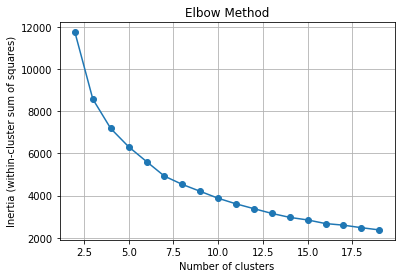

In [71]:

inertia_list = []

for k in range(2, 20):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia_list.append(km.inertia_)

plt.plot(range(2, 20), inertia_list, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.grid(True)
plt.show()


In [91]:
# Redo KMeans
kmeans = KMeans(n_clusters=729, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Store in a new df or overwrite
df_clustered = df_mean_per_time.copy()
df_clustered['cluster'] = labels

# Check results
print(df_clustered['cluster'].value_counts())

cluster
197    325
74     287
471    277
363    269
8      253
      ... 
387      1
661      1
592      1
595      1
514      1
Name: count, Length: 729, dtype: int64


In [ ]:
# df_clustered.to_csv("genes_with_clusters_k4.csv")

# # Optional: save individual clusters
# for c in range(4):
#     df_clustered[df_clustered['cluster'] == c].to_csv(f"cluster_{c}_genes.csv")


##Cluster by Plot##

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

KeyboardInterrupt: 

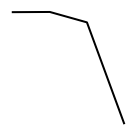

In [7]:
#Create and Save Expression Plots Per Probe

# Create output folder
os.makedirs("probe_plots", exist_ok=True)

# Loop through each probe and plot its expression
for probe_id, row in df_mean_per_time.iterrows():
    plt.figure(figsize=(2, 2))
    plt.plot(["0h", "24h", "48h", "72h"], row.values, color="black", linewidth=2)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"probe_plots/{probe_id}.png", dpi=64)
    plt.close()


In [ ]:


# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your plot image folder (all plots .png)
image_dir = "/content/drive/MyDrive/Colab Notebooks/final project/probe_plots"

# Transform: grayscale, resize, normalize
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),  # or (128, 128)
    transforms.ToTensor()
])

class PlotDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.file_paths = sorted([
            os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".png")
        ])
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert("RGB")
        return self.transform(img)

dataset = PlotDataset(image_dir, transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


**###time series cluster##**

In [5]:

import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, KShape
import numpy as np
import pandas as pd



In [13]:
X_scaled = pd.read_csv("X_scaled.csv")
X_scaled

,0h_mean,24h_mean,48h_mean,72h_mean
0,0.0,-0.093936,1.652815,2.502917
1,0.0,0.115451,-0.757021,-0.476990
2,0.0,-0.055327,0.063890,0.038211
3,0.0,-0.497864,-0.602445,-0.488579
4,0.0,0.819001,-0.053547,-0.067749
...,...,...,...,...
20690,0.0,1.420521,0.637760,0.356523
20691,0.0,0.113555,0.057827,0.028093
20692,0.0,-0.040660,-0.036721,-0.005136
20693,0.0,0.550468,1.321915,1.465912


In [14]:

# Step 2: Convert to 3D time series format

# X_scaled = X_scaled[:, :, np.newaxis]      
X_ts = to_time_series_dataset(X_scaled)


# Step 4: Clustering (you can try "dtw" or "euclidean")
model = TimeSeriesKMeans(n_clusters=27, metric="dtw", random_state=42)
labels = model.fit_predict(X_scaled)




KeyboardInterrupt: 

In [31]:
# Step 5: Attach labels back to your original data
df_with_labels = X_scaled.copy()
df_with_labels["cluster"] = labels

# # Optional: Save to CSV
df_with_labels.to_csv("tslearn_cluster_result.csv")

# Step 6: Quick check
df_with_labels.head()


,0h_mean,24h_mean,48h_mean,72h_mean,cluster
Probe_ID,,,,,
ILMN_1212602,0.0,-0.093936,1.652815,2.502917,18
ILMN_1212605,0.0,0.115451,-0.757021,-0.476990,13
ILMN_1212607,0.0,-0.055327,0.063890,0.038211,1
ILMN_1212619,0.0,-0.497864,-0.602445,-0.488579,13
ILMN_1212625,0.0,0.819001,-0.053547,-0.067749,22


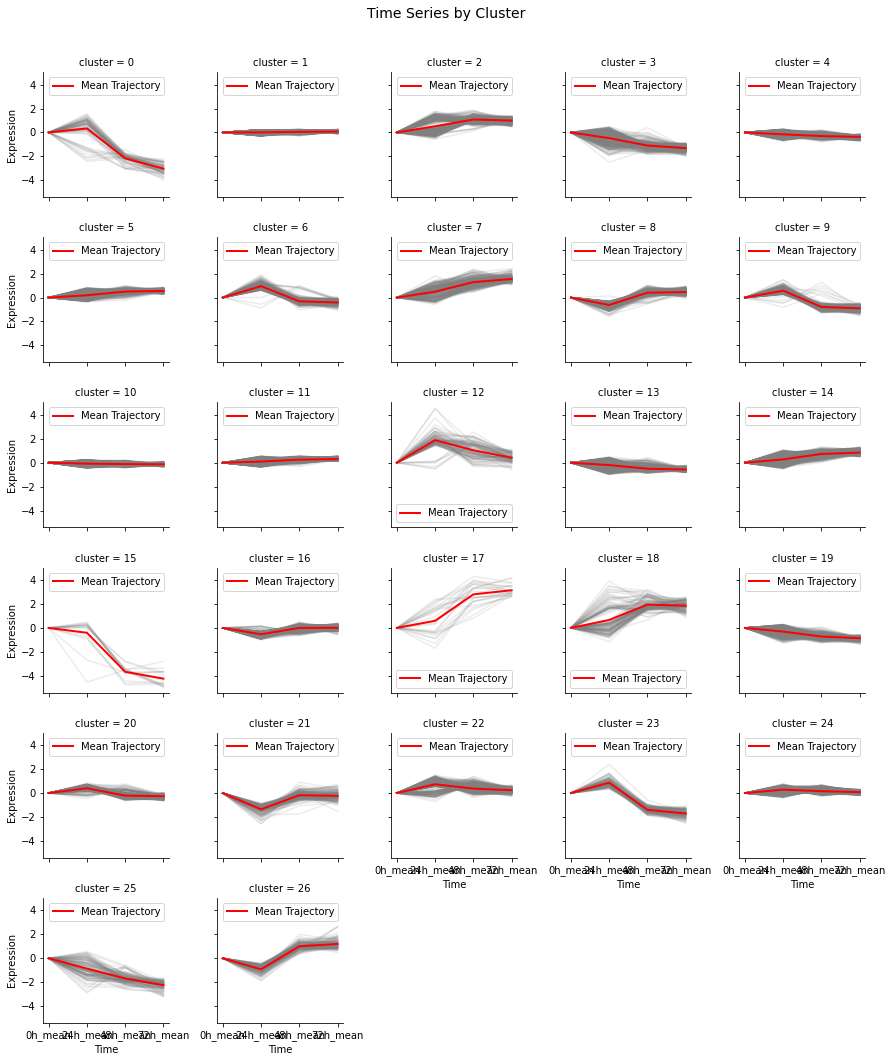

In [15]:
###visulization 
# Replace with your actual file path if needed
df = pd.read_csv("tslearn_cluster_result.csv")
df.head()
# Melt the data for seaborn lineplot
df_melted = df.reset_index().melt(id_vars=["Probe_ID", "cluster"], 
                                  value_vars=["0h_mean", "24h_mean", "48h_mean", "72h_mean"],
                                  var_name="Time", value_name="Expression")

g = sns.FacetGrid(df_melted, col="cluster", col_wrap=5, sharey=True, height=2.5)

# Plot individual lines
g.map_dataframe(sns.lineplot, x="Time", y="Expression", hue=None,
                units="Probe_ID", estimator=None, alpha=0.15, color="gray")

# Plot cluster mean
mean_df = df_melted.groupby(['cluster', 'Time'])['Expression'].mean().reset_index()
for ax, (cluster, group) in zip(g.axes.flat, mean_df.groupby("cluster")):
    sns.lineplot(data=group, x="Time", y="Expression", ax=ax, color="red", linewidth=2, label="Mean Trajectory")

plt.subplots_adjust(top=0.92)
g.fig.suptitle("Time Series by Cluster", fontsize=14)
plt.show()


In [27]:
df_with_labels = pd.read_csv("tslearn_cluster_result.csv",index_col=0)
df_with_labels.head(20)

,0h_mean,24h_mean,48h_mean,72h_mean,cluster
Probe_ID,,,,,
ILMN_1212602,0.0,-0.093936,1.652815,2.502917,18
ILMN_1212605,0.0,0.115451,-0.757021,-0.476990,13
ILMN_1212607,0.0,-0.055327,0.063890,0.038211,1
ILMN_1212619,0.0,-0.497864,-0.602445,-0.488579,13
ILMN_1212625,0.0,0.819001,-0.053547,-0.067749,22
ILMN_1212626,0.0,-0.077398,-0.541643,-0.574524,13
ILMN_1212633,0.0,0.549004,0.585843,0.606028,5
ILMN_1212636,0.0,0.253078,-0.689255,-0.612068,13
ILMN_1212637,0.0,-0.213758,-0.433522,-0.503440,4


In [19]:
# Step 5: Attach labels back to your original data
df2 = df_with_labels[df_with_labels["cluster"]==2]
X_scaled2 = df2.drop('cluster',axis=1)
X_scaled2

,0h_mean,24h_mean,48h_mean,72h_mean
Probe_ID,,,,
ILMN_1213167,0.0,1.391898,0.641241,0.710736
ILMN_1213978,0.0,0.819554,1.366622,1.040880
ILMN_1214110,0.0,1.227609,0.826506,0.970018
ILMN_1214469,0.0,0.040370,1.155352,0.774741
ILMN_1214486,0.0,-0.280936,1.058916,1.104660
...,...,...,...,...
ILMN_3150724,0.0,1.574803,0.996473,1.323507
ILMN_3152389,0.0,-0.257144,1.021940,1.106767
ILMN_3152792,0.0,0.231481,1.260949,1.147136


In [24]:
# X_scaled = X_scaled[:, :, np.newaxis]      
X_ts = to_time_series_dataset(X_scaled2)


# Step 4: Clustering (you can try "dtw" or "euclidean")
# model = TimeSeriesKMeans(n_clusters=10, metric="dtw", random_state=42)
model = KShape(n_clusters=10, random_state=0)
labels = model.fit_predict(X_scaled2)

In [25]:
# Step 5: Attach labels back to your original data
df_with_labels2 = X_scaled2.copy()
df_with_labels2["cluster"] = labels

# Step 6: Quick check
df_with_labels2.head()

,0h_mean,24h_mean,48h_mean,72h_mean,cluster
Probe_ID,,,,,
ILMN_1213167,0.0,1.391898,0.641241,0.710736,6
ILMN_1213978,0.0,0.819554,1.366622,1.040880,6
ILMN_1214110,0.0,1.227609,0.826506,0.970018,0
ILMN_1214469,0.0,0.040370,1.155352,0.774741,6
ILMN_1214486,0.0,-0.280936,1.058916,1.104660,0


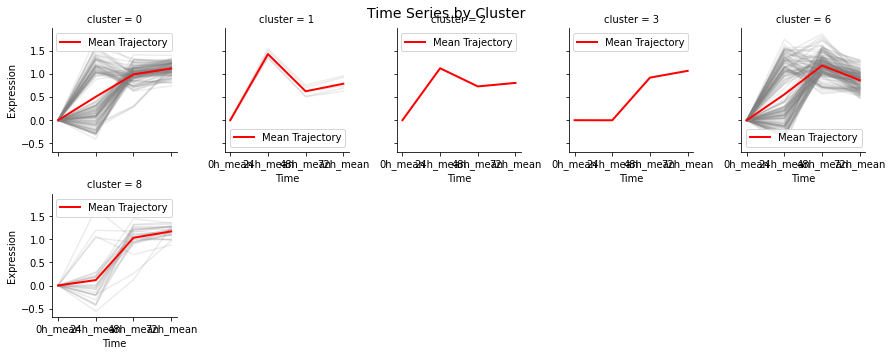

In [26]:
###visulization 
# Replace with your actual file path if needed
df = df_with_labels2
df.head()
# Melt the data for seaborn lineplot
df_melted = df.reset_index().melt(id_vars=["Probe_ID", "cluster"], 
                                  value_vars=["0h_mean", "24h_mean", "48h_mean", "72h_mean"],
                                  var_name="Time", value_name="Expression")

g = sns.FacetGrid(df_melted, col="cluster", col_wrap=5, sharey=True, height=2.5)

# Plot individual lines
g.map_dataframe(sns.lineplot, x="Time", y="Expression", hue=None,
                units="Probe_ID", estimator=None, alpha=0.15, color="gray")

# Plot cluster mean
mean_df = df_melted.groupby(['cluster', 'Time'])['Expression'].mean().reset_index()
for ax, (cluster, group) in zip(g.axes.flat, mean_df.groupby("cluster")):
    sns.lineplot(data=group, x="Time", y="Expression", ax=ax, color="red", linewidth=2, label="Mean Trajectory")

plt.subplots_adjust(top=0.92)
g.fig.suptitle("Time Series by Cluster", fontsize=14)
plt.show()


In [40]:
df_clustered = pd.read_csv("/Users/wangbeini/Documents/Columbia U/5243-bio/final project/cluster_plot_class_23_part_1/tslearn_cluster_result_with_subcluster.csv")
platform_df = pd.read_csv("/Users/wangbeini/Documents/Columbia U/5243-bio/final project/data + codebook/Platform_df.csv")
mapping_df = platform_df[['Probe_Id', 'Symbol']].drop_duplicates()

In [93]:

mapping_df = mapping_df.rename(columns={"Probe_Id": "Probe_ID", "Symbol": "Gene_Symbol"})

# Merge dataframes on 'Probe_ID'
merged_df = df_clustered.merge(mapping_df[['Probe_ID', 'Gene_Symbol']], on='Probe_ID', how='left')

# Check the result
print(merged_df.head())

# # Optional: Save to Excel or CSV
merged_df.to_csv("cluster_with_gene_names.csv", index=False)


       Probe_ID  X0h_mean  X24h_mean  X48h_mean  X72h_mean  cluster  \
0  ILMN_1212602         0  -0.093936   1.652815   2.502917       18   
1  ILMN_1212605         0   0.115451  -0.757021  -0.476990       13   
2  ILMN_1212607         0  -0.055327   0.063890   0.038211        1   
3  ILMN_1212619         0  -0.497864  -0.602445  -0.488579       13   
4  ILMN_1212625         0   0.819001  -0.053547  -0.067749       22   

   subcluster    Gene_Symbol  
0           1          Best1  
1           6  1500011K16Rik  
2           1          Cradd  
3           2         Mfap3l  
4           4           Parl  


In [94]:
merged_df

,Probe_ID,X0h_mean,X24h_mean,X48h_mean,X72h_mean,cluster,subcluster,Gene_Symbol
0,ILMN_1212602,0,-0.093936,1.652815,2.502917,18,1,Best1
1,ILMN_1212605,0,0.115451,-0.757021,-0.476990,13,6,1500011K16Rik
2,ILMN_1212607,0,-0.055327,0.063890,0.038211,1,1,Cradd
3,ILMN_1212619,0,-0.497864,-0.602445,-0.488579,13,2,Mfap3l
4,ILMN_1212625,0,0.819001,-0.053547,-0.067749,22,4,Parl
...,...,...,...,...,...,...,...,...
20690,ILMN_3163539,0,1.420521,0.637760,0.356523,22,9,Zmiz2
20691,ILMN_3163543,0,0.113555,0.057827,0.028093,1,8,Spn
20692,ILMN_3163569,0,-0.040660,-0.036721,-0.005136,1,3,Slc16a3
20693,ILMN_3163572,0,0.550468,1.321915,1.465912,7,2,Adcy7


In [95]:
merged_df['cluster_label'] = merged_df["cluster"].astype(str) + "_" + merged_df["subcluster"].astype(str)
merged_df

,Probe_ID,X0h_mean,X24h_mean,X48h_mean,X72h_mean,cluster,subcluster,Gene_Symbol,cluster_label
0,ILMN_1212602,0,-0.093936,1.652815,2.502917,18,1,Best1,18_1
1,ILMN_1212605,0,0.115451,-0.757021,-0.476990,13,6,1500011K16Rik,13_6
2,ILMN_1212607,0,-0.055327,0.063890,0.038211,1,1,Cradd,1_1
3,ILMN_1212619,0,-0.497864,-0.602445,-0.488579,13,2,Mfap3l,13_2
4,ILMN_1212625,0,0.819001,-0.053547,-0.067749,22,4,Parl,22_4
...,...,...,...,...,...,...,...,...,...
20690,ILMN_3163539,0,1.420521,0.637760,0.356523,22,9,Zmiz2,22_9
20691,ILMN_3163543,0,0.113555,0.057827,0.028093,1,8,Spn,1_8
20692,ILMN_3163569,0,-0.040660,-0.036721,-0.005136,1,3,Slc16a3,1_3
20693,ILMN_3163572,0,0.550468,1.321915,1.465912,7,2,Adcy7,7_2


In [ ]:
import numpy as np
import pandas as pd

# --- Step 1: Define trend by difference with per-step threshold ---
def get_difference_trend(row, diffs_thresholds):
    trend = []
    for i in range(1, len(row)):
        diff = row[i] - row[i - 1]
        threshold = diffs_thresholds[i - 1]  # threshold for this time step
        if diff >= threshold:
            trend.append('U')
        elif diff <= -threshold:
            trend.append('D')
        else:
            trend.append('S')
    return "_".join(trend)

# --- Step 2: Compute thresholds for each pair of time points ---
# diffs_thresholds = [
#     np.abs(merged_df['X24h_mean'] - merged_df['X0h_mean']).mean(),
#     np.abs(merged_df['X48h_mean'] - merged_df['X24h_mean']).mean(),
#     np.abs(merged_df['X72h_mean'] - merged_df['X48h_mean']).mean()
# ]

diffs_thresholds = [
    0.5,0.2,0.2
]

# --- Step 3: Compute cluster-level mean expression ---
time_cols = ['X0h_mean', 'X24h_mean', 'X48h_mean', 'X72h_mean']
cluster_means = merged_df.groupby('cluster_label')[time_cols].mean()

# --- Step 4: Compute trend label for each cluster ---
cluster_means['trend'] = cluster_means.apply(
    lambda row: get_difference_trend(row, diffs_thresholds), axis=1
)

# --- Step 5: Map trend labels back to full dataframe ---
trend_map = cluster_means['trend'].to_dict()
merged_df['trend'] = merged_df['cluster_label'].map(trend_map)


/var/folders/5g/1ml1dkqn1hx0_z8kyhhg3wqw0000gn/T/ipykernel_52805/3131455638.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = row[i] - row[i - 1]


In [118]:
merged_df

,Probe_ID,X0h_mean,X24h_mean,X48h_mean,X72h_mean,cluster,subcluster,Gene_Symbol,cluster_label,trend
0,ILMN_1212602,0,-0.093936,1.652815,2.502917,18,1,Best1,18_1,D_U_U
1,ILMN_1212605,0,0.115451,-0.757021,-0.476990,13,6,1500011K16Rik,13_6,S_D_S
2,ILMN_1212607,0,-0.055327,0.063890,0.038211,1,1,Cradd,1_1,S_S_S
3,ILMN_1212619,0,-0.497864,-0.602445,-0.488579,13,2,Mfap3l,13_2,D_S_S
4,ILMN_1212625,0,0.819001,-0.053547,-0.067749,22,4,Parl,22_4,U_D_S
...,...,...,...,...,...,...,...,...,...,...
20690,ILMN_3163539,0,1.420521,0.637760,0.356523,22,9,Zmiz2,22_9,U_D_D
20691,ILMN_3163543,0,0.113555,0.057827,0.028093,1,8,Spn,1_8,S_S_S
20692,ILMN_3163569,0,-0.040660,-0.036721,-0.005136,1,3,Slc16a3,1_3,S_S_S
20693,ILMN_3163572,0,0.550468,1.321915,1.465912,7,2,Adcy7,7_2,U_U_S


In [119]:
merged_df.groupby('trend')['cluster_label'].count()

trend
D_D_D      92
D_D_S     290
D_S_D      69
D_S_S    1634
D_S_U       2
D_U_D     208
D_U_S    1177
D_U_U     358
S_D_D      90
S_D_S    1221
S_D_U      17
S_S_D     168
S_S_S    8452
S_U_D     441
S_U_S    1121
S_U_U     267
U_D_D     454
U_D_S    2766
U_D_U       7
U_S_D     273
U_S_S     901
U_S_U      70
U_U_D      65
U_U_S     490
U_U_U      62
Name: cluster_label, dtype: int64

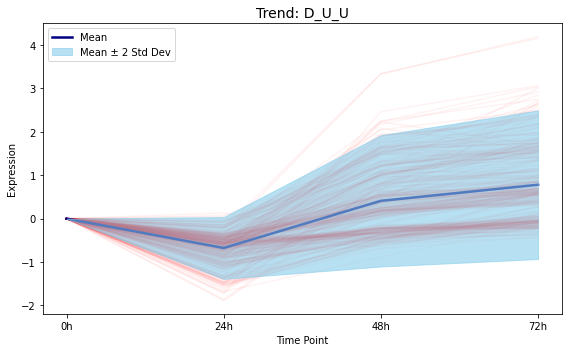

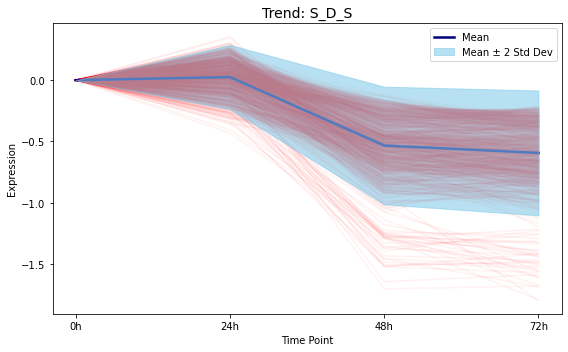

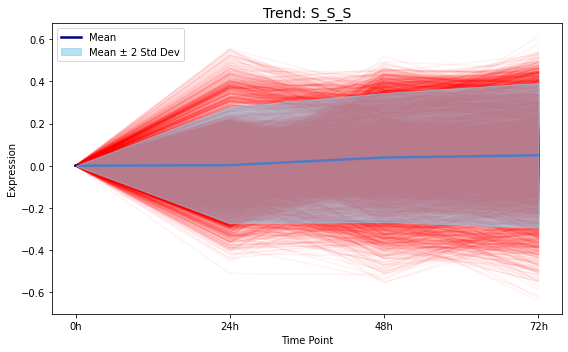

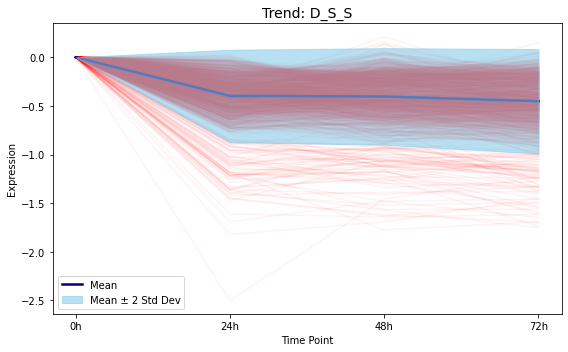

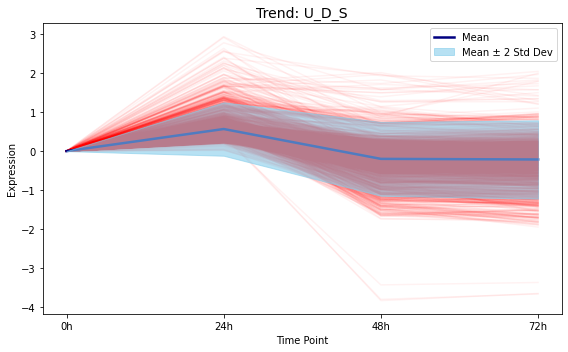

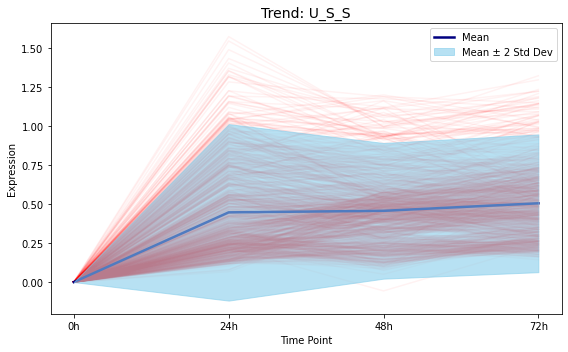

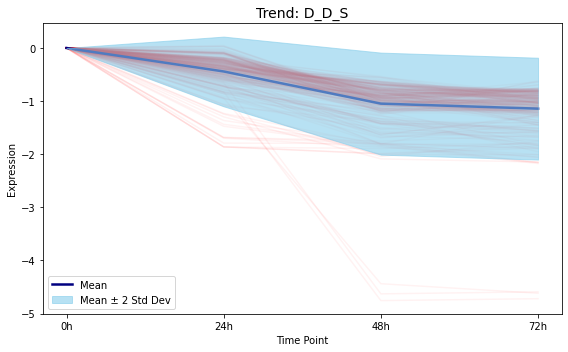

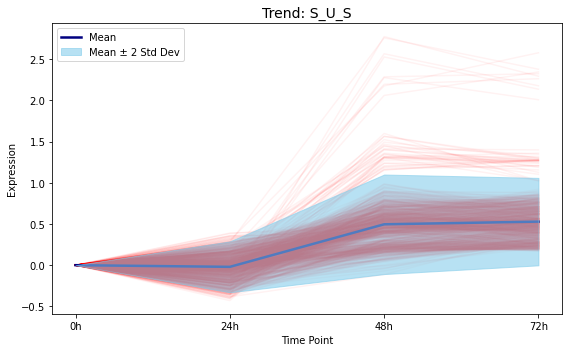

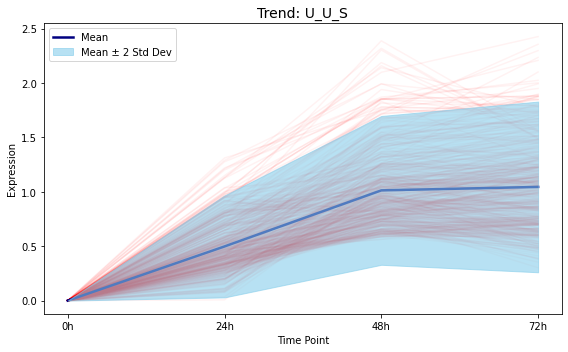

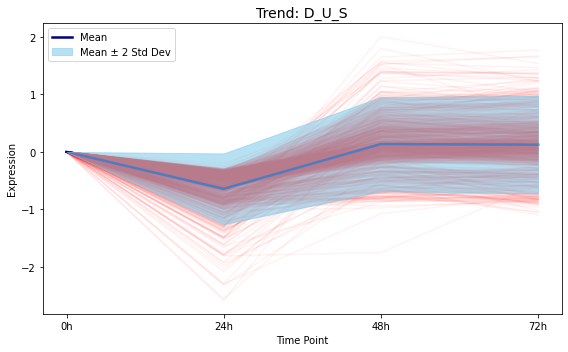

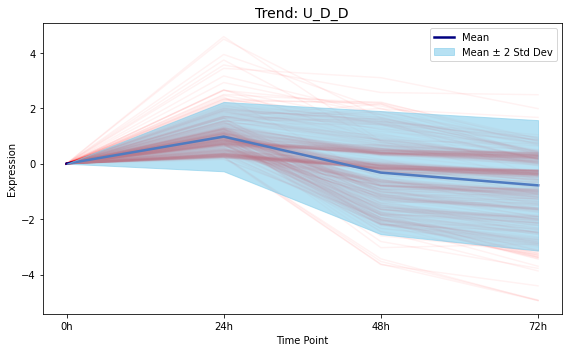

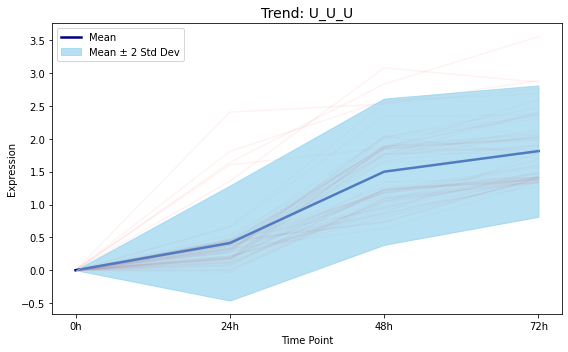

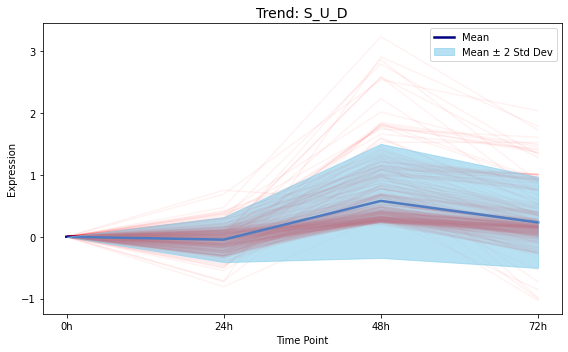

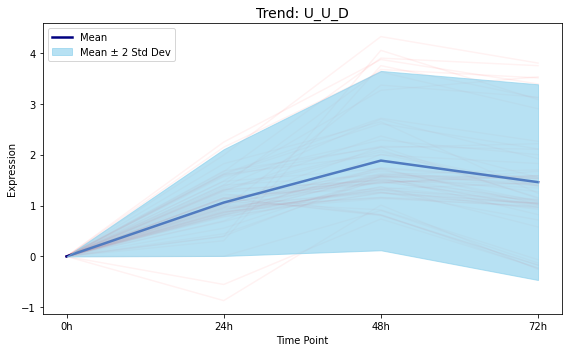

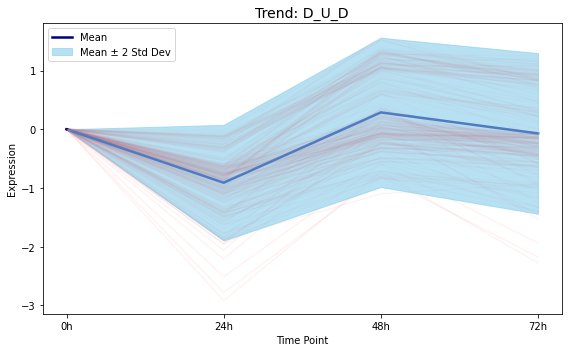

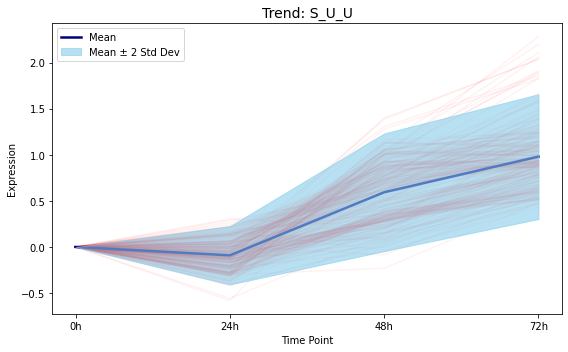

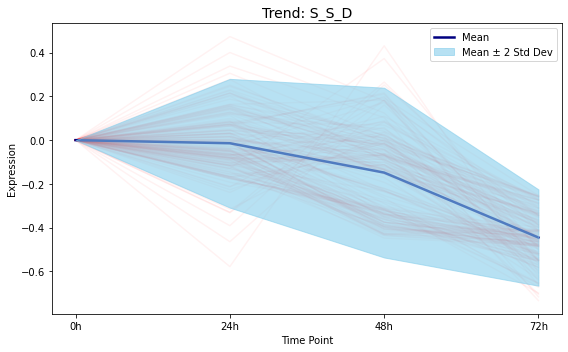

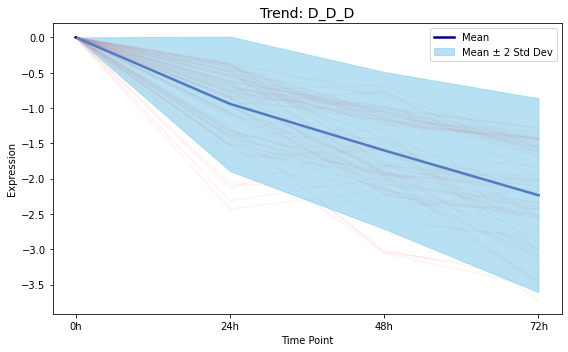

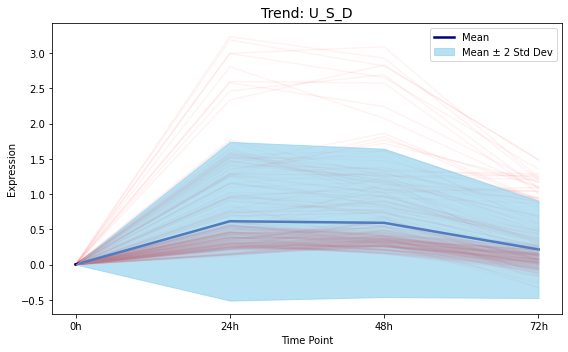

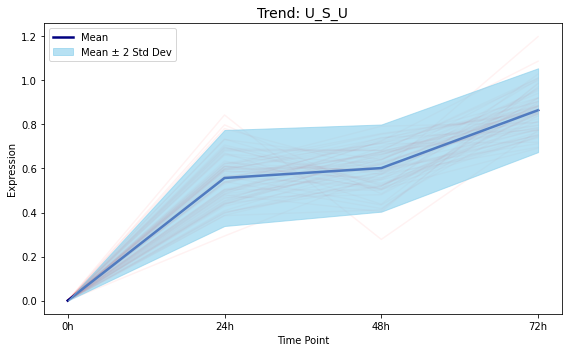

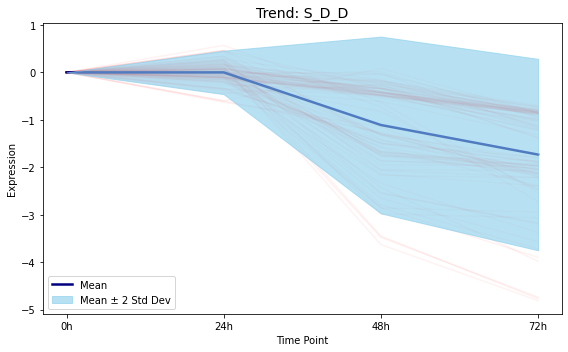

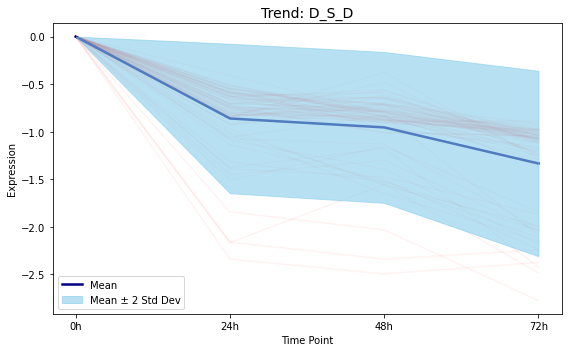

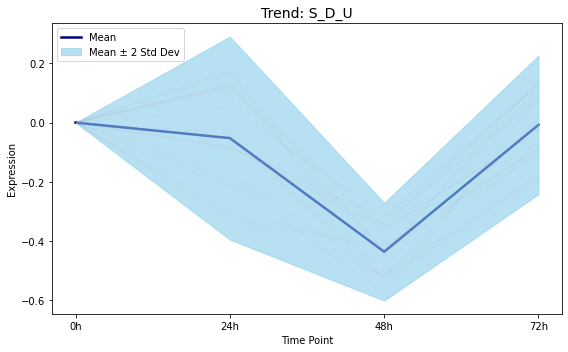

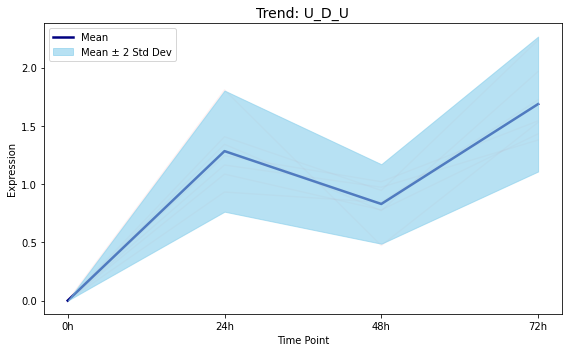

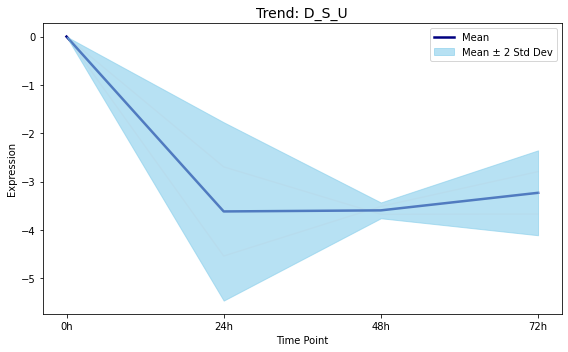

In [120]:
# Define columns and time axis
time_cols = ['X0h_mean', 'X24h_mean', 'X48h_mean', 'X72h_mean']
x = [0, 1, 2, 3]

for trend in merged_df['trend'].unique():
    df_trend = merged_df[merged_df['trend'] == trend]
    expr_matrix = df_trend[time_cols].values

    # Compute mean and ±2 standard deviations
    mean_vals = np.mean(expr_matrix, axis=0)
    std_vals = np.std(expr_matrix, axis=0)
    lower_bound = mean_vals - 2 * std_vals
    upper_bound = mean_vals + 2 * std_vals

    # Start plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title(f"Trend: {trend}", fontsize=14)

    # Spaghetti plots
    for row in expr_matrix:
        ax.plot(x, row, color='red', alpha=0.05, zorder=1)

    # Mean line
    ax.plot(x, mean_vals, color='navy', linewidth=2.5, label='Mean', zorder=2)

    # CI with ±2 std (plotted last)
    ax.fill_between(x, lower_bound, upper_bound, color='skyblue', alpha=0.6,
                    label='Mean ± 2 Std Dev', zorder=3)

    # Final plot settings
    ax.set_xticks(x)
    ax.set_xticklabels(['0h', '24h', '48h', '72h'])
    ax.set_xlabel("Time Point")
    ax.set_ylabel("Expression")
    ax.legend()
    plt.tight_layout()
    plt.show()
